In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [129]:
class Normalizer:    
    def __init__(self, method="l1", limits=[0,1], lamda=1, delta=None, power=1, axis=None):
        '''
        method:str - StandardScaler / Z-score scaler
                     MinMax / Linear Scaler (Squeeze values into a range defined by limits)
                     Box-Cox transformation (Convert any distribution to normal distribution)
                     Log Scaling
                     L1 / Manhattan / Taxicab normalization
                     L2 / Euclidean
                     Lp norm
                     Uniform / Supremum (Sup) / Chebyshev / Infinity / Maximum norm
                     Quantile https://en.wikipedia.org/wiki/Quantile_normalization
                     # TODO - Zero norm
                     Frobenius / Hilbert–Schmidt norm
                     # TODO - Lpq norm https://en.wikipedia.org/wiki/Matrix_norm#L2,1_and_Lp,q_norms
        limits:list(len=2) - if method is 'MinMax' Maximum and minimum value
        lamda:numeric - when method is Box-Cox, lamda is the term used in its formula
        delta:[numeric, None] - when method is Box-Cox, delta is the term to be added to make the data positive as is required by BoxCox
        power:numeric - when method is Lp norm, power is the term to used in the formula
        axis:[0, None] - if axis is 0, Vector norm is calculated, i.e, for each feature(column)
                         if axis is None, norm across whole X
        '''
        method = method.lower()
        if 'z' in method or 'standard' in method:
            self.method = 'z'
        elif 'minmax' in method or 'linear' in method:
            self.method = 'minmax'
            assert len(limits) == 2, "limits must have 1 maximum value and 1 minimum value"
            self.limits = sorted(limits)
        elif 'box' in method and 'cox' in method:    # To accomodate 'box-cox', 'boxcox', etc
            self.method = 'boxcox'
            self.lamda = float(lamda)            
            self.delta = delta if delta else None
        elif 'log' in method:
            self.method = 'log'
        elif 'l1' in method or 'taxicab' in method or 'manhattan' in method:
            self.method = 'l1'
        elif 'l2' in method or 'euclidean' in method or ('2' in method and 'norm' in method):    # To accomodate '2-norm', '2norm', etc
            self.method = 'l2'
        elif 'lp' in method:
            self.method = 'lp'
            self.power = power
        elif 'max' in method or 'supremum' in method or 'sup' in method or 'chebyshev' in method or 'infinity' in method or 'uniform' in method:
            self.method = 'max'
        elif 'quantile' in method:
            self.method = 'quantile'
        elif 'fro' in method or 'frobenius' in method or 'hilbert' in method or 'schmidt' in method:
            self.method = 'fro'
        else:
            print("Unrecognized method")
            raise NotImplementedError
        assert axis is None or axis == 0, "axis must be either 0 or None"
        self.axis = axis

    def normalize(self, X):
        if self.method == 'z':
            X = (X-X.mean(axis=self.axis)) / X.std(axis=self.axis)
        elif self.method == 'minmax':
            m = X.min(axis=0)
            X = (X - m) * (self.limits[1]-self.limits[0]) / (X.max(axis=self.axis) - m) + self.limits[0]
        elif self.method == 'log':
            X = np.log(X)
        elif self.method == 'boxcox':
            if self.delta:
                X += delta
            i = np.argwhere(X<=0)
            if i.any():
                print("Data must be positive for Box-Cox Transformation, shifting data +0.1 units of origin")
                if self.delta:
                    print("delta specified did not eliminate invalid values")
                if i.shape[1] == 1:
                    ind = np.unique(i)
                    X[ind] = X[ind] + (X[ind].min()+0.1)
                else:
                    ind = np.unique(i[:, 1])
                    X[:, ind] += (X[:, ind].min(axis=self.axis)+0.1)
            if self.lamda == 0:
                X = np.log(X)
            else:
                X = (X**self.lamda - 1) / self.lamda
        elif self.method == 'l1':
            X = X / np.sum(np.abs(X), axis=self.axis)
        elif self.method == 'l2':
            X = X / np.sqrt(np.sum(X**2, axis=self.axis))
        elif self.method == 'lp':
            X = X / np.sum(np.abs(X**self.power), axis=self.axis)**(1/float(self.power))
        elif self.method == 'max':
            X = X / X.max(axis=self.axis)
        elif self.method == 'quantile':
            print("Yet to do")
            raise NotImplementedError
        elif self.method == 'fro':
            flat = X.ravel()
            X = X / np.sqrt(flat @ flat)
        return X

# Comparing

In [38]:
X = np.array([[0,1,1], [3,0,3]])
np.sum(X.ravel(), axis=0)

8

In [128]:
Normalizer(method='lp', power=2).normalize(X)

array([[0.        , 0.2236068 , 0.2236068 ],
       [0.67082039, 0.        , 0.67082039]])

In [124]:
Normalizer(method='l2').normalize(X)

array([[0.        , 1.        , 0.31622777],
       [1.        , 0.        , 0.9486833 ]])

In [7]:
from scipy import stats

In [131]:
x = stats.loggamma.rvs(5, size=500) + 5

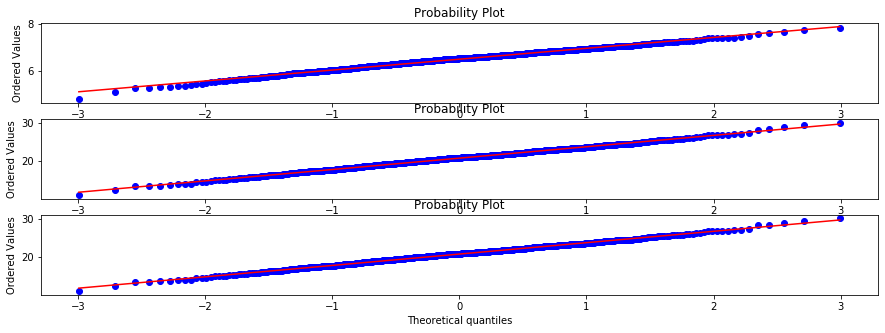

In [142]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(311)
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax2 = fig.add_subplot(312)
xt = stats.boxcox(x, 2)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)

ax3 = fig.add_subplot(313)
xtm = Normalizer(method='boxcox', lamda=2).normalize(x)
prob = stats.probplot(xtm, dist=stats.norm, plot=ax3)

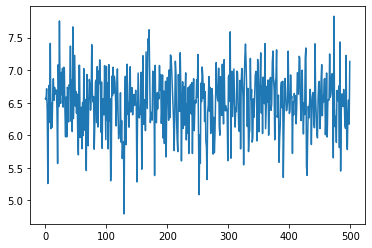

In [146]:
plt.plot(x)

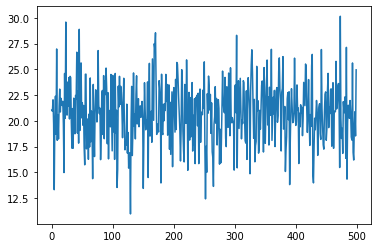

In [147]:
plt.plot(xt)